# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import joblib

# Data Loading and Preprocessing

In [2]:
def load_tif_files(directory):
    """
    Load and return a list of arrays representing TIFF files from a directory.
    Each array will have a shape of (3, h, w) corresponding to the bands.
    """
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = []
    
    for file_path in tif_files:
        with rasterio.open(file_path) as src:
            bands = src.read()  # shape (3, h, w)
            bands_list.append(bands)
    
    return bands_list

# Directories
non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

# Load all non-forest and forest files
non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)

print(f"Loaded {len(non_forest_data)} non-forest files and {len(forest_data)} forest files.")

Loaded 31 non-forest files and 45 forest files.


#### Preparing Features and Labels -  Using tiles

In [3]:
def extract_features_from_tile(tile):
    """
    Extract statistical features from a tile, focusing on VV, VH, and the mean of the Incidence Angle.
    """
    tile_features = []
    
    # Process the first two bands (Band 1 - VV, Band 2 - VH)
    for band in range(2):  # Process Bands 1 and 2
        band_data = tile[band]
        tile_features.extend([
            band_data.mean(),  # Mean
            band_data.std(),   # Standard deviation
            band_data.min(),   # Min value
            band_data.max(),   # Max value
            np.median(band_data)  # Median
        ])
    
#     # Add the mean value of Band 3 (Incidence Angle)
#     band3_mean = np.log(tile[2].mean() + 1)    # Assuming Band 3 is at index 2
#     tile_features.append(band3_mean)  # Append only the mean value of Band 3
    
    return tile_features

In [4]:
def extract_features_from_tile(tile):
    """
    Extract statistical features from a tile, including VV, VH, and incidence angle ratios.
    """
    tile_features = []
    
    # Process the first two bands (Band 1 - VV, Band 2 - VH)
    for band in range(2):  # Process Bands 1 and 2
        band_data = tile[band]
        incidence_angle = tile[2]  # Assuming Band 3 is at index 2
        
        # Calculate basic statistics
        tile_features.extend([
            band_data.mean(),  
            band_data.std(),   
            band_data.min(),   
            band_data.max(),   
            np.median(band_data),
        ])
        
        # Calculate ratio features
        ratio = band_data / (incidence_angle + 1e-5)  # Add small epsilon to avoid division by zero
        tile_features.extend([
            ratio.mean(),
            ratio.std(),
            ratio.min(),
            ratio.max(),
            np.median(ratio)
        ])
    
    return tile_features


In [5]:
def extract_features_from_tile(tile):
    """
    Extract statistical features from a tile, including VV, VH, and the mean ratio for the incidence angle.
    """
    tile_features = []
    
    # Process the first two bands (Band 1 - VV, Band 2 - VH)
    for band in range(2):  # Process Bands 1 and 2
        band_data = tile[band]
        incidence_angle = tile[2]  # Assuming Band 3 is at index 2
        
        # Calculate basic statistics without median
        tile_features.extend([
            band_data.mean(),  
            band_data.std(),   
            band_data.min(),   
            band_data.max(),
        ])
        
        # Calculate only the mean ratio feature
        mean_ratio = (band_data / (incidence_angle + 1e-5)).mean()
        tile_features.append(mean_ratio)
    
    return tile_features


In [6]:
def tile_image(image_data, tile_size=16):
    """
    Divide an image into tiles, filtering out any tiles that contain NaN values,
    and compute statistical features for each valid tile.
    """
    h, w = image_data.shape[1], image_data.shape[2]
    tiles = []

    for i in range(0, h, tile_size):
        for j in range(0, w, tile_size):
            tile = image_data[:, i:i+tile_size, j:j+tile_size]  # Include all three bands
            if tile.shape[1] == tile_size and tile.shape[2] == tile_size:
                if not np.isnan(tile).any():  # Ensure the tile has no NaN values
                    tile_features = extract_features_from_tile(tile)
                    tiles.append(tile_features)
    
    return np.array(tiles)

In [7]:
selected_tile_size = 8

# Apply tiling and feature extraction to all non-forest and forest images
non_forest_tiles = np.vstack([tile_image(bands, tile_size=selected_tile_size) for bands in non_forest_data])
forest_tiles = np.vstack([tile_image(bands, tile_size=selected_tile_size) for bands in forest_data])

# Combine and label tiles
X = np.vstack([non_forest_tiles, forest_tiles])
y = np.hstack([np.zeros(non_forest_tiles.shape[0]), np.ones(forest_tiles.shape[0])])

print(f"Tile feature matrix shape: {X.shape}, Labels shape: {y.shape}")  ## 10 features, 5 for each of the 2 bands

y_int = y.astype(int)

# Count the number of occurrences of each class
class_counts = np.bincount(y_int)

# Calculate the percentage of each class
non_forest_percentage = class_counts[0] / len(y_int) * 100
forest_percentage = class_counts[1] / len(y_int) * 100

print(f"Number of Non-Forest samples: {class_counts[0]} ({non_forest_percentage:.2f}%)")
print(f"Number of Forest samples: {class_counts[1]} ({forest_percentage:.2f}%)")

Tile feature matrix shape: (316730, 10), Labels shape: (316730,)
Number of Non-Forest samples: 13644 (4.31%)
Number of Forest samples: 303086 (95.69%)


In [8]:
# Split the data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_norm = scaler.fit_transform(X_train)

# Apply the same transformation to the validation and test data
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

# Now you can use the normalized data for training and evaluating your models


Training set size: 221711 samples
Validation set size: 47509 samples
Test set size: 47510 samples


# Classification Method 1: Random Forest

In [9]:
# Train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_norm, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Validation Accuracy: 0.9856
Classification Report (Validation Set):
              precision    recall  f1-score   support

  Non-Forest       0.97      0.69      0.80      2044
      Forest       0.99      1.00      0.99     45465

    accuracy                           0.99     47509
   macro avg       0.98      0.84      0.90     47509
weighted avg       0.99      0.99      0.98     47509



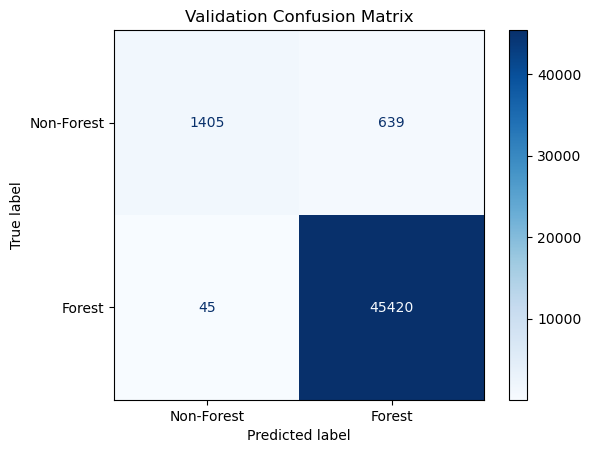

In [10]:
# Validate the model
rf_val_predictions = rf_classifier.predict(X_val_norm)
rf_val_accuracy = (rf_val_predictions == y_val).mean()
print(f"Validation Accuracy: {rf_val_accuracy:.4f}")

# Detailed performance report
print("Classification Report (Validation Set):")
print(classification_report(y_val, rf_val_predictions, target_names=['Non-Forest', 'Forest']))

# Generate the confusion matrix for the validation set
val_conf_matrix = confusion_matrix(y_val, rf_val_predictions)

# Plot the confusion matrix for the validation set
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()


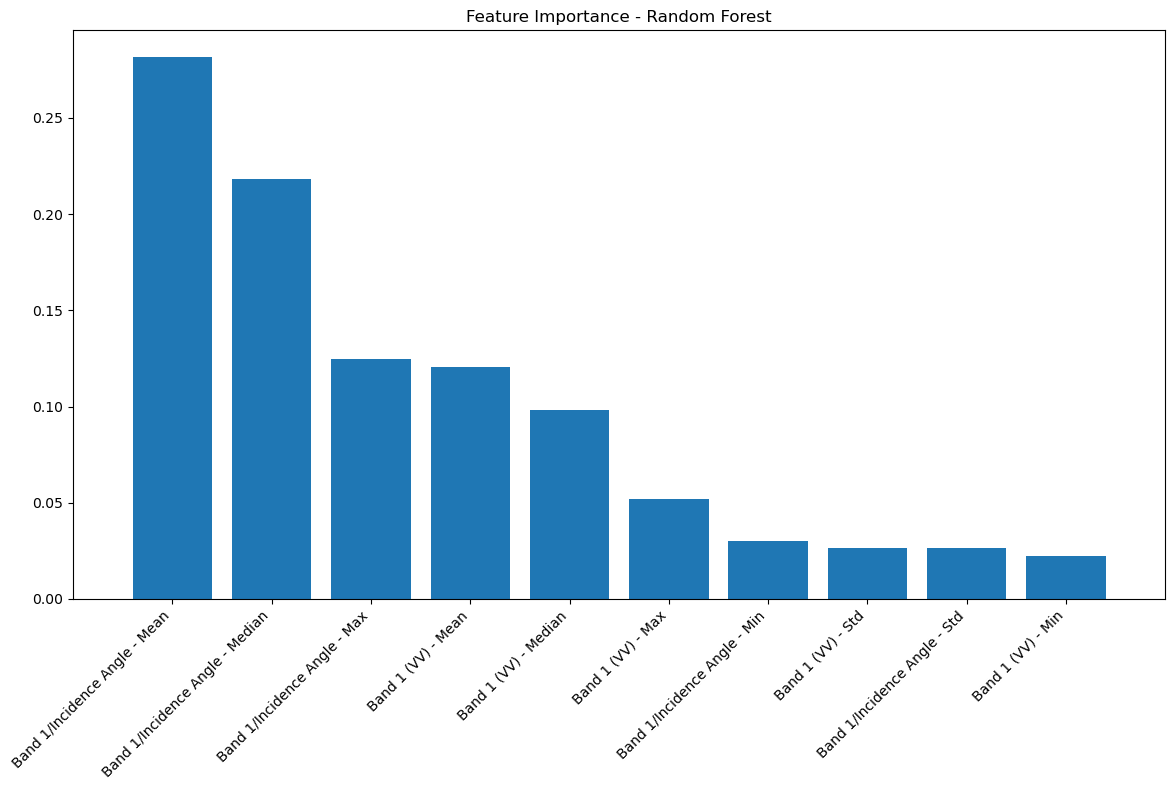

In [11]:
feature_importances = rf_classifier.feature_importances_

# Assuming you've added ratio features for VV and VH with Incidence Angle
feature_names_full = [
    'Band 1 (VV) - Mean', 'Band 1 (VV) - Std', 'Band 1 (VV) - Min', 'Band 1 (VV) - Max', 'Band 1 (VV) - Median',
    'Band 1/Incidence Angle - Mean', 'Band 1/Incidence Angle - Std', 'Band 1/Incidence Angle - Min', 
    'Band 1/Incidence Angle - Max', 'Band 1/Incidence Angle - Median',
    
    'Band 2 (VH) - Mean', 'Band 2 (VH) - Std', 'Band 2 (VH) - Min', 'Band 2 (VH) - Max', 'Band 2 (VH) - Median',
    'Band 2/Incidence Angle - Mean', 'Band 2/Incidence Angle - Std', 'Band 2/Incidence Angle - Min', 
    'Band 2/Incidence Angle - Max', 'Band 2/Incidence Angle - Median'
]

# Calculate feature importances
feature_importances = rf_classifier.feature_importances_

# Sort the features by importance
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importance - Random Forest")
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names_full)[indices], rotation=45, ha="right")
plt.xlim([-1, len(feature_importances)])
plt.tight_layout()
plt.show()


# Classification Method 2: SVM

In [12]:
# Train the SVM model
svm_classifier = SVC(probability=True, class_weight='balanced')
svm_classifier.fit(X_train_norm, y_train)


SVC(class_weight='balanced', probability=True)

In [ ]:
# Validate the SVM model
svm_val_predictions = svm_classifier.predict(X_val_norm)
svm_val_accuracy = (svm_val_predictions == y_val).mean()
print(f"SVM Validation Accuracy: {svm_val_accuracy:.4f}")

# Detailed performance report
print("Classification Report (Validation Set):")
print(classification_report(y_val, svm_val_predictions, target_names=['Non-Forest', 'Forest']))

# Generate the confusion matrix for the validation set
val_conf_matrix = confusion_matrix(y_val, svm_val_predictions)

# Plot the confusion matrix for the validation set
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()



#### SVM grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [ 'auto', 0.001],
    'kernel': ['linear', 'sigmoid'],
#     'degree': [2, 3, 4]  # Only relevant if 'poly' kernel is selected
}

# Initialize the SVC model
svm_classifier = SVC(probability=True)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid,
                           n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search.fit(X_train_norm, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Output the results
print(f"Best parameters found: {best_params}")
print(f"Best training accuracy: {best_score:.4f}")

# Evaluate the best model on the validation set
best_svm_classifier = grid_search.best_estimator_
y_val_pred = best_svm_classifier.predict(X_val_norm)

# Evaluate the best model on the validation set
from sklearn.metrics import classification_report, confusion_matrix

print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# If satisfied with the validation performance, you can evaluate it on the test set as well
y_test_pred = best_svm_classifier.predict(X_test_norm)

print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits


# Classification Method 2: XGB

In [11]:
# import xgboost as xgb
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# # Convert your data to DMatrix, which is optimized for XGBoost
# dtrain = xgb.DMatrix(X_train_norm, label=y_train)
# dval = xgb.DMatrix(X_val_norm, label=y_val)
# dtest = xgb.DMatrix(X_test_norm, label=y_test)

# # Set the XGBoost parameters
# params = {
#     'objective': 'binary:logistic',  # Binary classification
#     'eval_metric': 'logloss',  # Evaluation metric
#     'eta': 0.1,  # Learning rate
#     'max_depth': 6,  # Depth of the trees
#     'lambda': 10,  # L2 regularization term
#     'alpha': 10,  # L1 regularization term
#     'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
#     'scale_pos_weight': 1,  # Control balance of positive and negative weights
#     # 'min_child_weight': 5  # Optionally add if you need stronger regularization
# }

# # Add feature importance constraints if needed
# # Assuming the last feature in X corresponds to the incidence angle mean
# fmap = {0: 'Band 1 Mean', 1: 'Band 1 Std', 2: 'Band 1 Min', 3: 'Band 1 Max', 4: 'Band 1 Median',
#         5: 'Band 2 Mean', 6: 'Band 2 Std', 7: 'Band 2 Min', 8: 'Band 2 Max', 9: 'Band 2 Median',
#         10: 'Band 3 Mean'}

# # Optional: If you want to penalize Band 3 (the incidence angle), you can set higher regularization or lower weights
# feature_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1,
#                    5: 1, 6: 1, 7: 1, 8: 1, 9: 1,
#                    10: 0.00001}  # Lower weight for Band 3 (Incidence Angle Mean)

# # Custom objective function or feature selection isn't directly available, but this can guide model design

# # Train the XGBoost model
# evals = [(dtrain, 'train'), (dval, 'eval')]
# xgb_model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10)

In [12]:
# # Predict on the test set
# xgb_test_predictions = xgb_model.predict(dtest)
# xgb_test_predictions = (xgb_test_predictions > 0.5).astype(int)  # Threshold at 0.5 for binary classification

# # Evaluate the model
# xgb_test_accuracy = (xgb_test_predictions == y_test).mean()
# print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")

# # Confusion Matrix
# xgb_test_conf_matrix = confusion_matrix(y_test, xgb_test_predictions)
# disp_xgb_test = ConfusionMatrixDisplay(confusion_matrix=xgb_test_conf_matrix, display_labels=['Non-Forest', 'Forest'])
# disp_xgb_test.plot(cmap=plt.cm.Blues)
# plt.title("XGBoost Test Confusion Matrix")
# plt.show()

# print("XGBoost Classification Report (Test Set):")
# print(classification_report(y_test, xgb_test_predictions, target_names=['Non-Forest', 'Forest']))

# # Feature Importance Plot
# xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
# plt.title("XGBoost Feature Importance")
# plt.show()

# RF vs. SVM

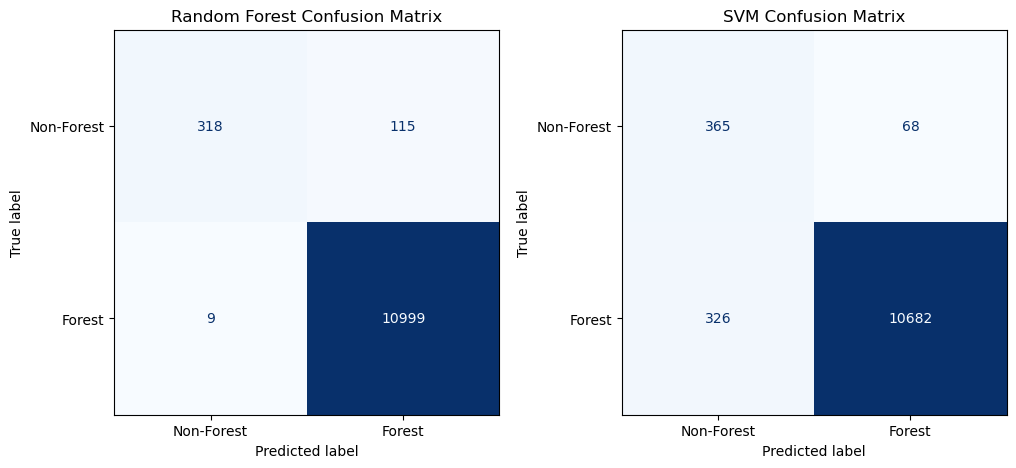

           Model  Accuracy  Precision (Non-Forest)  Recall (Non-Forest)  \
0  Random Forest  0.989162                0.972477             0.734411   
1            SVM  0.965562                0.528220             0.842956   

   F1-Score (Non-Forest)  Precision (Forest)  Recall (Forest)  \
0               0.836842            0.989653         0.999182   
1               0.649466            0.993674         0.970385   

   F1-Score (Forest)  
0           0.994395  
1           0.981892  


IndexError: index 2 is out of bounds for axis 0 with size 2

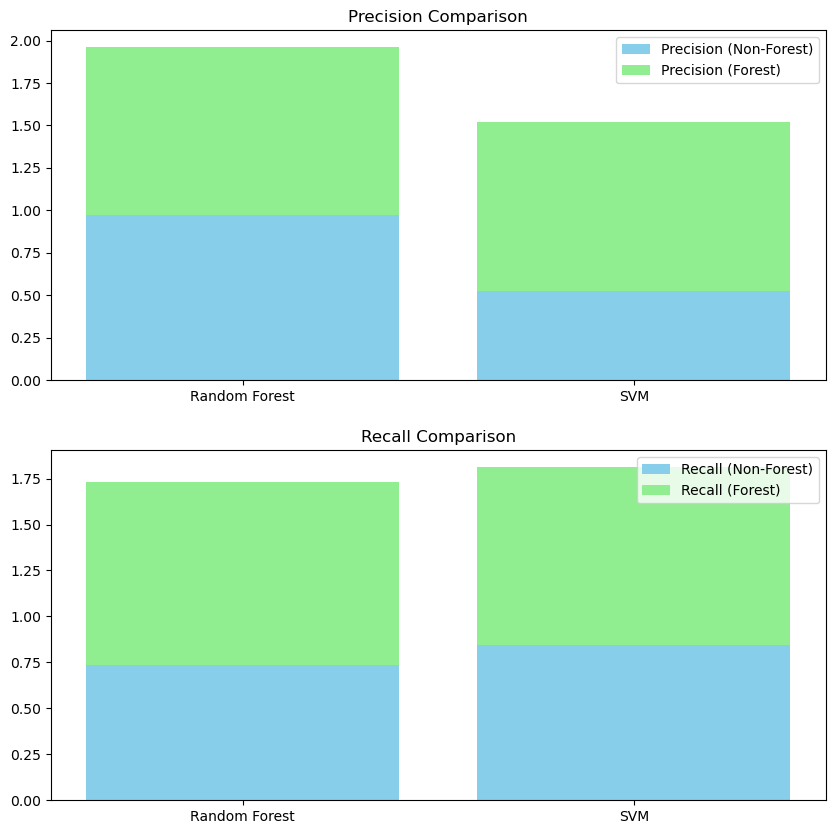

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Random Forest Test Evaluation
rf_test_predictions = rf_classifier.predict(X_test_norm)
rf_test_accuracy = (rf_test_predictions == y_test).mean()
rf_test_conf_matrix = confusion_matrix(y_test, rf_test_predictions)
rf_classification_report = classification_report(y_test, rf_test_predictions, target_names=['Non-Forest', 'Forest'], output_dict=True)

# SVM Test Evaluation
svm_test_predictions = svm_classifier.predict(X_test_norm)
svm_test_accuracy = (svm_test_predictions == y_test).mean()
svm_test_conf_matrix = confusion_matrix(y_test, svm_test_predictions)
svm_classification_report = classification_report(y_test, svm_test_predictions, target_names=['Non-Forest', 'Forest'], output_dict=True)

# Plotting Confusion Matrices Side by Side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest Confusion Matrix
disp_rf_test = ConfusionMatrixDisplay(confusion_matrix=rf_test_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_rf_test.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Random Forest Confusion Matrix")

# SVM Confusion Matrix
disp_svm_test = ConfusionMatrixDisplay(confusion_matrix=svm_test_conf_matrix, display_labels=['Non-Forest', 'Forest'])
disp_svm_test.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title("SVM Confusion Matrix")

plt.show()

# Creating a Summary DataFrame for Key Metrics
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM'],
    'Accuracy': [rf_test_accuracy, svm_test_accuracy],
    'Precision (Non-Forest)': [rf_classification_report['Non-Forest']['precision'], svm_classification_report['Non-Forest']['precision']],
    'Recall (Non-Forest)': [rf_classification_report['Non-Forest']['recall'], svm_classification_report['Non-Forest']['recall']],
    'F1-Score (Non-Forest)': [rf_classification_report['Non-Forest']['f1-score'], svm_classification_report['Non-Forest']['f1-score']],
    'Precision (Forest)': [rf_classification_report['Forest']['precision'], svm_classification_report['Forest']['precision']],
    'Recall (Forest)': [rf_classification_report['Forest']['recall'], svm_classification_report['Forest']['recall']],
    'F1-Score (Forest)': [rf_classification_report['Forest']['f1-score'], svm_classification_report['Forest']['f1-score']]
})

print(metrics_df)

# Visualizing the Metrics
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics_to_plot):
    axes[idx].bar(metrics_df['Model'], metrics_df[f'{metric} (Non-Forest)'], color='skyblue', label=f'{metric} (Non-Forest)')
    axes[idx].bar(metrics_df['Model'], metrics_df[f'{metric} (Forest)'], color='lightgreen', label=f'{metric} (Forest)', bottom=metrics_df[f'{metric} (Non-Forest)'])
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].legend()

plt.tight_layout()
plt.show()


# Save the selected classifier

In [15]:
# Assuming svm_classifier is your trained SVM model
model_path = r'D:\Development\RESEARCH\MarvinBlue\Results\svm_model.pkl'
joblib.dump(svm_classifier, model_path)

print(f"SVM model saved to {model_path}")

# Save the fitted scaler to a file
scaler_path = r'D:\Development\RESEARCH\MarvinBlue\Results\scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

SVM model saved to D:\Development\RESEARCH\MarvinBlue\Results\svm_model.pkl
Scaler saved to D:\Development\RESEARCH\MarvinBlue\Results\scaler.pkl
